> Copyright 2022 Bruno César Brito Sant'Anna <mail@bsantanna.me>
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [48]:
import matplotlib.pyplot as plt
import os
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [49]:
# Globals
batch_size = 32
num_epochs = 500

In [50]:
# Utility functions
# Original Sources:
# - https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# - https://github.com/open-ibans/ibans-python

def bban_to_regex(bban_format: str):
    bban_formats_list = bban_format.split(",")
    regex_list = []
    for x in bban_formats_list:
        type = x[-1]
        size = x[:-1]
        if type == "a":
            regex_list.append(f"[A-Z]{{{size}}}")
        elif type == "c":
            regex_list.append(f"[A-Za-z0-9]{{{size}}}")
        elif type == "n":
            regex_list.append(f"[0-9]{{{size}}}")
    bban_regex = "".join(regex_list)
    return bban_regex


def build_model(dataset):
    # Categorical feature
    feature_code = tf.keras.Input(shape=(1,), name="Code", dtype="string")
    feature_code_encoded = encode_categorical_feature(feature_code, "Code", dataset, is_string=True)

    # Numerical feature
    feature_size = tf.keras.Input(shape=(1,), name="Size", dtype="int64")
    feature_size_encoded = encode_numerical_feature(feature_size, "Size", dataset)

    # Inputs
    inputs = [
        feature_code,
        feature_size
    ]

    features = tf.keras.layers.concatenate([
        feature_code_encoded,
        feature_size_encoded
    ])

    input_layer = tf.keras.layers.Dense(batch_size, activation="relu")(features)
    output_layer = tf.keras.layers.Dense(len(iban_data), activation="softmax")(input_layer)

    model = tf.keras.Model(inputs, output_layer)
    model.compile("adam", "categorical_crossentropy", metrics=[
        "accuracy",
    ])

    return model

def dataframe_to_dataset(dataframe):
    df = dataframe.drop(["JSON"], axis=1)
    labels = tf.keras.utils.to_categorical(dataframe["JSON"].factorize()[0])
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds


def encode_numerical_feature(feature, name, dataset):
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)

    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string=False, use_lookup=True, max_tokens=0):
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # for x, y in feature_ds.take(1):
    #     print("Input:", x)
    #     print("Target:", y)

    if use_lookup:
        encoding_layer_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
        encoding_layer = encoding_layer_class(output_mode="binary")
        encoding_layer.adapt(feature_ds)

    elif is_string:
        encoding_layer = tf.keras.layers.TextVectorization()
        encoding_layer.adapt(feature_ds)

    else:
        encoding_layer = tf.keras.layers.Hashing(num_bins=max_tokens, output_mode="one_hot")

    encoded_feature = encoding_layer(feature)
    return encoded_feature


def predict_json(trained_model, code, size):
    prediction = trained_model.predict({
        "Code": tf.convert_to_tensor([code]),
        "Size": tf.convert_to_tensor([size])
    }, verbose = 0)
    # return max probability
    return iban_data["JSON"][prediction.argmax()]


In [51]:
# Structured tabular iban data
# Original Source: https://github.com/open-ibans/ibans-python
iban_data = pd.read_csv("../../ibans.txt", sep="|")
iban_data["BBAN_Regex"] = iban_data["BBAN Format"].transform(lambda x: bban_to_regex(x))
iban_data["Check_Digit_Regex"] = iban_data["IBAN Fields"].transform(lambda x: x[2:4].replace("k", "[0-9]"))
iban_data["Size_String"] = iban_data["Size"].transform(lambda x: str(x))
iban_data["JSON"] = "{" \
    + "\"country\":\"" + iban_data["Country"] \
    + "\",\"bban_regex\":\"" + iban_data["BBAN_Regex"] \
    + "\",\"check_digit_regex\":\"" + iban_data["Check_Digit_Regex"] \
    + "\",\"code\":\"" + iban_data["Alpha"] \
    + "\",\"size\":" + iban_data["Size_String"] \
    + "}"
iban_data["Code"] = iban_data["Alpha"]
iban_data = iban_data.drop(["Alpha", "BBAN Format", "BBAN_Regex", "Check_Digit_Regex", "Country", "IBAN Fields", "Size_String"], axis=1)

iban_data.to_csv("../../processed_ibans.csv", sep=";", quotechar="'",index=False)

# print(iban_data.shape)
# print(iban_data.isna().sum())
# iban_data.sample(3)

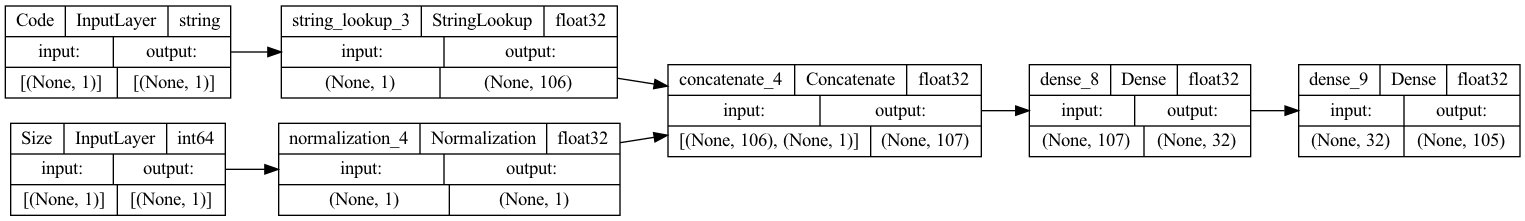

In [52]:
# initialize dataset
train_dataset = dataframe_to_dataset(iban_data).batch(batch_size)

# initialize train_model
train_model = build_model(train_dataset)

# print model
tf.keras.utils.plot_model(train_model, show_shapes=True, show_dtype=True, rankdir="LR")

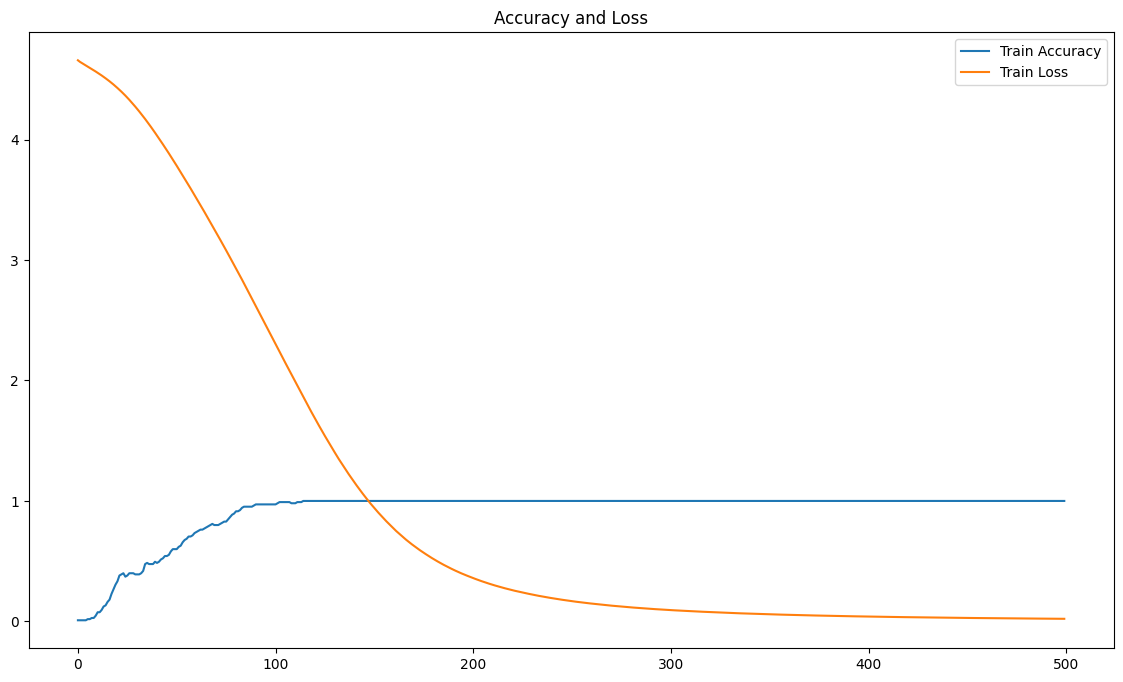

In [53]:
# train model and plot results
training_history = train_model.fit(train_dataset, epochs=num_epochs, verbose=0)

train_acc = training_history.history["accuracy"]
train_loss = training_history.history["loss"]

epochs_range = range(num_epochs)
plt.figure(figsize=(14, 8))
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.title("Accuracy and Loss")
plt.legend()

In [54]:
train_model.save("bin")
#restored_model = tf.keras.models.load_model("bin")
# restored_model.summary()

INFO:tensorflow:Assets written to: bin/assets


INFO:tensorflow:Assets written to: bin/assets


In [55]:
iban_data.sample(3)

,Size,JSON,Code
65,28,"{""country"":""Morocco"",""bban_regex"":""[0-9]{24}"",...",MA
63,21,"{""country"":""Latvia"",""bban_regex"":""[A-Z]{4}[A-Z...",LV
53,27,"{""country"":""Italy"",""bban_regex"":""[A-Z]{1}[0-9]...",IT


In [59]:
print("JSON Result: {}".format(predict_json(train_model, code="MA", size=28)))

JSON Result: {"country":"Morocco","bban_regex":"[0-9]{24}","check_digit_regex":"[0-9][0-9]","code":"MA","size":28}


In [60]:
print("JSON Result: {}".format(predict_json(train_model, code="LV", size=21)))

JSON Result: {"country":"Latvia","bban_regex":"[A-Z]{4}[A-Za-z0-9]{13}","check_digit_regex":"[0-9][0-9]","code":"LV","size":21}


In [61]:
print("JSON Result: {}".format(predict_json(train_model, code="IT", size=27)))


JSON Result: {"country":"Italy","bban_regex":"[A-Z]{1}[0-9]{10}[A-Za-z0-9]{12}","check_digit_regex":"[0-9][0-9]","code":"IT","size":27}
